## Dataset: MovieLens 100k
我選擇的是最小的資料規模，因為換到大一點的資料，我的記憶體就沒辦法load了。
選擇這麼小的data，結果movie和user的個數是差不多的。

不知道是不是因為這個原因，兩個演算法的效能在這裡比較不出什麼。

|               | $\|err\| <0.5$ | Converge | MAE      |   |
|---------------|----------------|----------|----------|---|
| Item-Based CF | 0.3121         | 0.9981   | 0.125065 |   |
| User-Based CF | 0.3176         | 0.9981   | 0.125065 |   |

## 程式碼

import方便做資料處理的lib。

In [144]:
%pylab inline
import pandas as pd
import numpy as np

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [145]:
# Load data
train = pd.read_table('ml-100k/u3.base', header=None, names=['uid', 'mid', 'rating', 'timestamp'])
test  = pd.read_table('ml-100k/u3.test', header=None, names=['uid', 'mid', 'rating', 'timestamp'])

n_users  = int(train.describe().loc['max', 'uid'])
n_movies = int(train.describe().loc['max', 'mid'])

 - $Y_{i, j}$放第$j$個使用者對第$i$部電影所做的評分
 - $R_{i, j}=1$代表第$j$個使用者對第$i$部電影有評分，$R_{i, j}=0$則無

In [146]:
# Transform
Y = np.zeros( (n_movies, n_users) )
R = Y.copy()
for i in range(train.shape[0]):
    Y[train.mid[i]-1][train.uid[i]-1] = train.rating[i]
    R[train.mid[i]-1][train.uid[i]-1] = 1

## Item-based Collaborative Filtering

In [147]:
# Allocate
weights    = np.empty((n_movies,n_movies))
diff       = np.empty((n_movies, n_users))
std_rating = np.empty(n_movies)

Y_mu = Y.sum(axis=1)/R.sum(axis=1)
item_has_rated = (R.sum(axis=1)!=0)
user_has_rated = (R.sum(axis=0)!=0)
R_movie = np.array([1 if i in item_has_rated else 0 for i in range(n_movies)])
for i in range(n_movies):
    diff[i,:] = Y[i,:]-Y_mu[i]
    std_rating[i] = np.power(diff[i,:],2).sum()/(R[i,:].sum())

In [148]:
# Weighting (Pearson correlation)
R_weights = np.zeros((n_movies, n_movies))
rate_avg = Y.sum()/float(R.sum())
for i in range(n_movies):
    for j in range(n_movies):
        stdmstd = std_rating[i]*std_rating[j]
        weights[i,j] = np.dot(R[i,:]*diff[i,:], R[j,:]*diff[j,:])/(stdmstd)
        #weights[i,j] = np.dot(R[i,:]*(Y[i,:]-rate_avg), R[j,:]*(Y[j,:]-rate_avg))/(stdmstd) # (constrainted Pearson)
        if stdmstd!=0 and item_has_rated[i] and item_has_rated[j]:
            R_weights[i,j] = 1

In [149]:
# Predict
pred_correlation = np.empty(test.shape[0])
pred_flag        = pred_correlation.copy()
K         = 50
tolerence = .5
count_not_available = 0
for test_id in range(test.shape[0]):
    a = test.uid[test_id]
    i = test.mid[test_id]

    if not user_has_rated[a] or not item_has_rated[i]:
        count_not_available = count_not_available + 1
        pred_flag[test_id] = 0
    else:
        weights_i = weights[i,:]*R_weights[i,:]
        sort_index = np.argsort(-weights_i)
        idx_positive_weights    = np.array(sort_index[1:K+1])
        val_positive_weights    = weights_i[idx_positive_weights]
        val_positive_difference = (diff[idx_positive_weights,a]) * (R[idx_positive_weights,a])
        pred = Y_mu[i] + np.dot(val_positive_difference,val_positive_weights)/(val_positive_weights.sum())
        if np.isnan(pred):
            count_not_available = count_not_available + 1
            pred_flag[test_id] = 0
        else:
            pred_correlation[test_id] = pred
            pred_flag[test_id] = 1
pred_has_pred = [i for i in range(test.shape[0]) if pred_flag[i] ]

In [150]:
# Validation
tolerence = .5
error_item_based   = test.rating.iloc[pred_has_pred] - pred_correlation[np.ix_(pred_has_pred)]
correct = np.array(error_item_based.loc[abs(error_item_based)<tolerence])

correct_proportion = correct.shape[0]/float(test.shape[0])
converge_item_based = 1 - (count_not_available/float(test.shape[0]))
MAE_item_based      = error_item_based.mean()

('Correct proportion:', 0.31175)
('Converge:', 0.98195)
('MAE:', 0.12491077129623541)


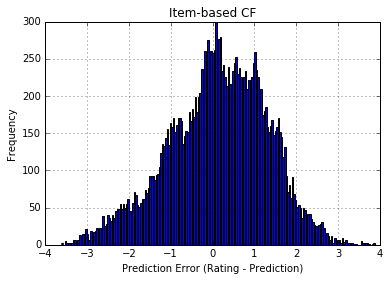

In [151]:
# Visualization
error_item_based.hist(bins=200)
plt.xlabel("Prediction Error (Rating - Prediction)")
plt.ylabel("Frequency")
plt.title("Item-based CF")
print ('Correct proportion:', correct_proportion)
print ('Converge:',  converge_item_based)
print ('MAE:', MAE_item_based)

## User-based Collaborative Filtering

In [152]:
# Load data
train = pd.read_table('ml-100k/u2.base', header=None, names=['uid', 'mid', 'rating', 'timestamp'])
test  = pd.read_table('ml-100k/u2.test', header=None, names=['uid', 'mid', 'rating', 'timestamp'])

n_users  = int(train.describe().loc['max', 'uid'])
n_movies = int(train.describe().loc['max', 'mid'])

In [153]:
# Transform
Y = np.zeros( (n_movies, n_users) )
R = Y.copy()
for i in range(train.shape[0]):
    Y[train.mid[i]-1][train.uid[i]-1] = train.rating[i]
    R[train.mid[i]-1][train.uid[i]-1] = 1

In [154]:
# Allocate
weights    = np.empty((n_users,n_users))
diff       = np.empty((n_movies, n_users))
std_rating = np.empty(n_users)

Y_mu = Y.sum(axis=0)/R.sum(axis=0)
item_has_rated = (R.sum(axis=1)!=0)
user_has_rated = (R.sum(axis=0)!=0)
R_users = np.array([1 if i in user_has_rated else 0 for i in range(n_users)])
for i in range(n_users):
    diff[:,i] = Y[:,i]-Y_mu[i]
    std_rating[i] = np.power(diff[:,i],2).sum()/(R[:,i].sum())

In [155]:
# Weighting (Pearson correlation)
R_weights = np.zeros((n_users, n_users))
rate_avg = Y.sum()/float(R.sum())
for i in range(n_users):
    for j in range(n_users):
        stdmstd = std_rating[i]*std_rating[j]
        weights[i,j] = np.dot(R[:,i]*diff[:,i], R[:,j]*diff[:,j])/(stdmstd)
        #weights[i,j] = np.dot(R[:,i]*(Y[:,i]-rate_avg), R[:,j]*(Y[:,j]-rate_avg))/(stdmstd) # (constrainted Pearson)
        if stdmstd!=0:
            R_weights[i,j] = 1

In [156]:
# Predict
pred_correlation = np.zeros(test.shape[0])
pred_flag        = pred_correlation.copy()
pred_cosine      = pred_correlation.copy()
K         = 50
tolerence = .5
count_not_available = 0
for test_id in range(test.shape[0]):
    a = test.uid[test_id]
    i = test.mid[test_id]
    if not user_has_rated[a] or not item_has_rated[i]:
        count_not_available = count_not_available + 1
        pred_flag[test_id] = 0
    else:
        weights_i = weights[a,:]*R_weights[a,:]
        sort_index = np.argsort(-weights_i)
        idx_positive_weights    = np.array(sort_index[1:K+1])
        val_positive_weights    = weights_i[idx_positive_weights]
        val_positive_difference = (diff[i,idx_positive_weights] * R[i,idx_positive_weights])
        pred = Y_mu[a] + np.dot(val_positive_difference,val_positive_weights)/(val_positive_weights.sum())
        if np.isnan(pred):
            count_not_available = count_not_available + 1
            pred_flag[test_id] = 0
        else:
            pred_correlation[test_id] = pred
            pred_flag[test_id] = 1
pred_has_pred = [i for i in range(test.shape[0]) if pred_flag[i]] 
# Validation
error_user_based   = test.rating.iloc[pred_has_pred] - pred_correlation[np.ix_(pred_has_pred)]
correct = np.array(error_user_based.loc[abs(error_user_based)<tolerence])

correct_proportion = correct.shape[0]/float(test.shape[0])
converge_user_based = 1 - (count_not_available/float(test.shape[0]))
MAE_user_based      = error_item_based.mean()

0.3161
('Converge:', 0.9981)
('MAE:', 0.12491077129623541)


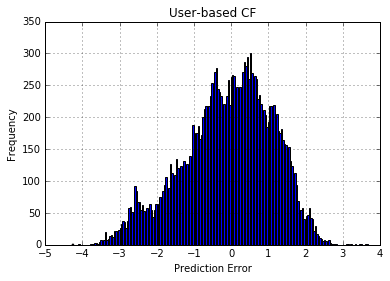

In [157]:
error_user_based.hist(bins=200)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("User-based CF")
print correct_proportion
print ('Converge:',  converge_user_based)
print ('MAE:', error_item_based.mean())